# Step 3: Train and evaluate the Calorimetric method

In [1]:
distances = [15, 35]
doubleplanes = [8, 12, 20, 30]
energies = [200, 600, 1000]
erels = [100, 500, 1000]
neutrons = [1, 2, 3, 4, 5, 6]
physicss = ["bert", "bic", "inclxx"]

## a) Train calorimetric method for all settings

In [2]:
import joblib

from train import train

joblib.Parallel(n_jobs=-1, backend="loky", verbose=1)(
    joblib.delayed(train)(distance=distance, doubleplane=doubleplane, energy=energy, nmax=neutron, physics=physics)
    for distance in distances
    for energy in energies
    for doubleplane in doubleplanes
    for neutron in neutrons
    for physics in physicss
)

print("Done")

Welcome to JupyROOT 6.16/00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  6.6min finished


Done


## b) Evaluate performance

In [3]:
import os
import shutil
import subprocess

import numpy as np
import pandas as pd
import ROOT
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, plot_confusion_matrix

from helpers import filename_for

In [4]:
ROOT.ROOT.EnableThreadSafety()
ROOT.FairLogger.GetLogger().SetLogVerbosityLevel("LOW")
ROOT.FairLogger.GetLogger().SetLogScreenLevel("WARNING")
ROOT.gROOT.SetBatch(True)

In [5]:
import warnings

warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")

For each event, apply the cuts and list the predicted multiplicity along with the number of incoming neutrons, the number of primary points, etc.

In [6]:
def neuland_calorimetric_data(distance, doubleplane, energy, erel, nmax, physics):
    ncutfile = f"output/{physics}/{distance}m_{doubleplane}dp_{energy}AMeV_{nmax}n.ncut.root"
    file = ROOT.TFile.Open(ncutfile)
    para = file.R3BNeulandMultiplicityCalorimetricPar
    para2 = file.R3BNeulandMultiplicityBayesPar

    data = []
    num_ex = 0
    for neutron in range(1, nmax + 1):
        digifile = filename_for(distance, doubleplane, energy, erel, neutron, physics, ".digi.root")
        tfile = ROOT.TFile.Open(digifile)
        ttree = tfile.Get("evt")
        for event in ttree:
            # nPN: Number of incoming primary neutrons
            nIn = neutron
            # nPP: Number of primary neutrons with an energy deposition in NeuLAND
            nPP = event.NeulandPrimaryPoints.GetEntries()
            # nPH: Number of hits that correspond to a energy deposition of a primary neutron
            nPH = event.NeulandPrimaryHits.GetEntries()
            # nHits: Number of hits
            num_hits = event.NeulandHits.GetEntries()
            # nClus: Number of clusters
            num_clusters = event.NeulandClusters.GetEntries()
            # Edep: Total deposited (detected) energy
            try:
                edep = round(sum([hit.GetE() for hit in event.NeulandHits]))
            except:
                num_ex += 1
                edep = 0

            # Use calibrated calorimetric method (R3BNeulandNeutron2DPar) from the parameter file
            # to predict the multiplicity
            mult = para.GetNeutronMultiplicity(edep, num_clusters)
            mult2_prob = para2.GetProbabilities(num_hits, num_clusters, edep)
            mult2 = np.argmax(mult2_prob)

            data.append([nIn, nPP, nPH, num_hits, num_clusters, edep, mult, mult2, *mult2_prob])
    datapd = pd.DataFrame(data)
    datapd.columns = ["nIn", "nPP", "nPH", "num_hits", "num_cluster", "edep", "calorimetric", "bayes", 0, 1, 2, 3, 4, 5, 6]
    return datapd

In [7]:
data = {energy: neuland_calorimetric_data(distance=15, doubleplane=30, energy=energy, erel=500, nmax=5, physics="inclxx") for energy in energies}

pd.options.display.max_rows = 20
display(data[600])

,nIn,nPP,nPH,num_hits,num_cluster,edep,calorimetric,bayes,0,1,2,3,4,5,6
0,1,1,1,8,2,203,1,1,0.0,0.995533,4.462130e-03,0.000004,8.016124e-09,0.000000e+00,0.0
1,1,1,1,12,1,320,1,1,0.0,0.989024,1.094658e-02,0.000029,0.000000e+00,0.000000e+00,0.0
2,1,1,1,13,6,287,1,1,0.0,0.952234,4.745631e-02,0.000309,1.015686e-06,2.676379e-09,0.0
3,1,1,1,12,5,317,1,1,0.0,0.968417,3.137877e-02,0.000204,5.604061e-07,1.376919e-09,0.0
4,1,1,1,14,8,287,1,1,0.0,0.875440,1.234917e-01,0.001064,4.615041e-06,1.298770e-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5,5,5,29,17,693,3,3,0.0,0.000000,3.390862e-01,0.591640,6.805221e-02,1.221847e-03,0.0
49996,5,5,5,68,13,981,3,4,0.0,0.000000,0.000000e+00,0.225527,5.999949e-01,1.744782e-01,0.0
49997,5,4,4,46,25,771,4,4,0.0,0.000000,2.766880e-03,0.332748,5.511009e-01,1.133840e-01,0.0
49998,5,5,5,67,29,991,4,5,0.0,0.000000,4.988947e-08,0.009151,3.433144e-01,6.475349e-01,0.0


Example neutron separation matrices and balanced accuracy score

In [8]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

for energy, df in data.items():
    print(energy)
    y_true = df[["nIn"]].values.ravel()
    y_pred = df[["calorimetric"]].values.ravel()

    bac = balanced_accuracy_score(y_true, y_pred)
    print(bac)
    cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
    cmrel = np.swapaxes(cmrel, 0, 1)
    print(cmrel)

200
0.62586
[[0.    0.068 0.004 0.    0.    0.   ]
 [0.    0.903 0.276 0.047 0.007 0.001]
 [0.    0.029 0.625 0.28  0.065 0.013]
 [0.    0.    0.095 0.531 0.292 0.087]
 [0.    0.    0.    0.139 0.464 0.293]
 [0.    0.    0.    0.003 0.173 0.607]]
600
0.6488999999999999
[[0.    0.052 0.003 0.    0.    0.   ]
 [0.    0.912 0.224 0.03  0.004 0.   ]
 [0.    0.036 0.664 0.257 0.053 0.009]
 [0.    0.    0.108 0.565 0.288 0.079]
 [0.    0.    0.001 0.146 0.495 0.303]
 [0.    0.    0.    0.002 0.16  0.609]]
1000
0.6625800000000001
[[0.    0.042 0.002 0.    0.    0.   ]
 [0.    0.888 0.181 0.021 0.003 0.   ]
 [0.    0.061 0.706 0.245 0.048 0.006]
 [0.    0.003 0.101 0.619 0.307 0.086]
 [0.    0.002 0.004 0.107 0.537 0.345]
 [0.    0.004 0.006 0.008 0.105 0.562]]


## c) Create Latex files with multiplicity matrices

In [9]:
def to_tabular(energy, bac, cm, nmax):
    text = ""
    text += "\\resizebox{0.32\\textwidth}{!}{\n"
    text += "\\begin{tabular}{cc|" + "S[table-format=2]" * nmax + "}\n"
    text += "\\toprule\n"
    text += "\\multicolumn{2}{c|}{" + str(energy) + "} & \\multicolumn{" + str(nmax) + "}{c}{generated} \\\\\n"
    text += "\\multicolumn{2}{c|}{MeV} &" + " & ".join([str(n) for n in range(1, nmax + 1)]) + " \\\\\n"
    text += "\\midrule\n"
    text += "\\multirow{" + str(nmax + 1) + "}{*}{\\rotatebox[origin=c]{90}{detected}}\n"

    for i, a in enumerate(cm[: nmax + 1]):
        text += " & " + str(i)
        for j, x in enumerate(a[1 : nmax + 1]):
            if j == i - 1:
                text += " & \\textbf{" + str(int(round(x * 100))) + "}"
            else:
                text += " & " + str(int(round(x * 100)))
        text += " \\\\\n"

    text += "\\bottomrule\n"
    text += "\\end{tabular}}"
    return text

In [10]:
def to_full_latex(data, distance, doubleplane, energy, erel, nmax, physics, algo):
    text = """\\documentclass{{scrartcl}}
\\usepackage{booktabs}
\\usepackage{siunitx}
\\usepackage{multirow}
\\usepackage{graphicx}
\\begin{document}
\\begin{table}
"""
    text += f"""\\captionabove[Neutron separation matrices for multiplicities of 1 to {nmax} neutrons]{{
Neutron separation matrices for multiplicities of 1 to {nmax} neutrons.
Columns display the neutron multiplicity simulated, rows the neutron multiplicity derived from the {algo} algorithm.
Values are given in percent.
Neutrons were simulated with 200 (left), 600 (center) and 1000 MeV (right matrix).
NeuLAND with {doubleplane} doubleplanes was located at a distance of {distance} m to the target.
Neutrons were generated with a relative energy of {erel} keV with respect to a medium heavy projectile fragment.
The distance between target and NeuLAND was filled with air and a 4\\,mm steel window.
Simulated with Geant4 using the \\texttt{{QGSP\\_{physics.upper()}\\_HP}} physics list.
Note that other maximum multiplicities will result in different efficiencies.
\\label{{tab:neutron-separation-matrices}}}}
"""
    for o in data:
        text += to_tabular(*o, nmax) + "\n"
    text += """\\end{table}
\\end{document}
"""
    return text

In [11]:
def process(distance, doubleplane, erel, nmax, physics, algo, data):
    out = []
    for energy, df in data.items():
        y_true = df[["nIn"]].values.ravel()
        y_pred = df[[algo]].values.ravel()

        bac = balanced_accuracy_score(y_true, y_pred)
        cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
        cmrel = np.swapaxes(cmrel, 0, 1)
        out.append([energy, bac, cmrel])

    fpath = "results/multiplicity/"
    fbase = f"{distance}m-{doubleplane:02d}dp-{algo}-{nmax}n"
    with open(fpath + fbase + ".tex", "w") as f:
        latex = to_full_latex(out, distance, doubleplane, energy, erel, nmax, physics, algo)
        f.write(latex)
    subprocess.call(["lualatex", fbase + ".tex"], cwd=fpath, stdout=subprocess.DEVNULL)
    os.remove(fpath + fbase + ".aux")
    os.remove(fpath + fbase + ".log")

In [12]:
erel = 500
physics = "inclxx"

for distance in distances:
    for doubleplane in doubleplanes:
        for nmax in neutrons:
            data = {energy: neuland_calorimetric_data(distance, doubleplane, energy, erel, nmax, physics) for energy in energies}
            for algo in ["calorimetric", "bayes"]:
                process(distance, doubleplane, erel, nmax, physics, algo, data)

## d) Plot Calibr Visualization

In [ ]:
import rootpy.tree

from plotconfroot import *

In [14]:
parfile = rootpy.io.root_open(f"output/inclxx/15m_30dp_600AMeV_4n.ncut.root", "read")
cpar = parfile.R3BNeulandMultiplicityCalorimetricPar
file = rootpy.io.root_open(f"output/inclxx/15m_30dp_600AMeV_4n.train.root", "read")

In [15]:
norm = mpl.colors.LogNorm(vmin=1e1, vmax=1e3, clip=False)

Using matplotlib backend: agg


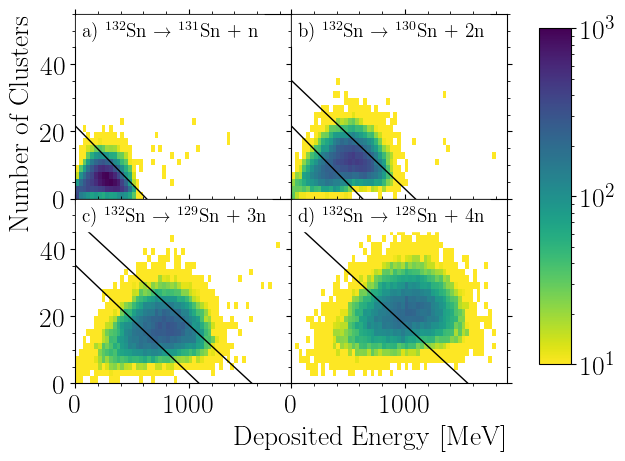

In [16]:
%matplotlib


def doit(i, ax, text, ty):
    h = file.Get(f"NeulandMultiplicityCalorimetricTrain/hnPN{i}")
    cut = cpar.GetNeutronCut(i)
    ax.text(0.03, ty, text, transform=ax.transAxes, size="x-small", backgroundcolor="white")
    im = rplt.imshow(h, axes=ax, cmap=mpl.cm.viridis_r, norm=norm, colorbar=False)
    ax.plot(list(cut.GetX()), list(cut.GetY()), color="black", linewidth=1)
    return im


fig = plt.figure()
axes = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True, gridspec_kw={"wspace": 0, "hspace": 0})

axes[0][0].set_xlim(0, 1900)
axes[0][0].set_ylim(0, 55)

doit(1, axes[0][0], "a) $^{132}$Sn → $^{131}$Sn + n", 0.88)
doit(2, axes[0][1], "b) $^{132}$Sn → $^{130}$Sn + 2n", 0.88)
doit(3, axes[1][0], "c) $^{132}$Sn → $^{129}$Sn + 3n", 0.88)
im4 = doit(4, axes[1][1], "d) $^{132}$Sn → $^{128}$Sn + 4n", 0.88)

axes[1][1].set_xlabel(r"Deposited Energy [MeV]", horizontalalignment="right", x=1)
axes[0][0].set_ylabel(r"Number of Clusters", horizontalalignment="right", y=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im4, cax=cbar_ax)

fig.savefig(f"results/calibr-1234n.pdf", bbox_inches="tight")
fig.savefig(f"results/calibr-1234n.png", bbox_inches="tight")

display(fig)

Using matplotlib backend: agg
[-1.0, -1.0, 655.9016892092368, -1.0, -1.0, 1121.6400114847509, 1587.378333760265, -1.0] [-1.0, -1.0, -1.0, 21.705214709520718, 35.25693681063392, -1.0, -1.0, 48.80865891174711]


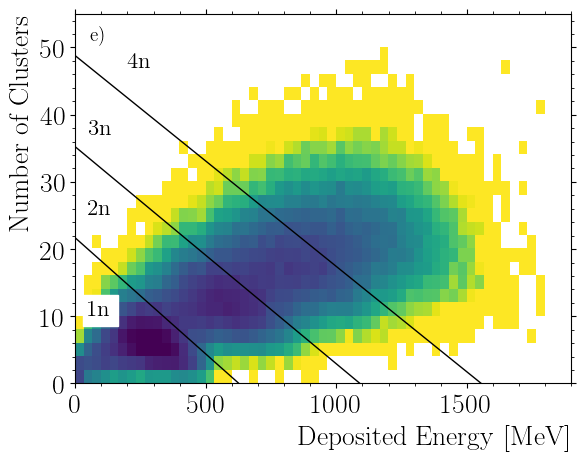

In [17]:
%matplotlib

h1 = file.Get(f"NeulandMultiplicityCalorimetricTrain/hnPN1")
h2 = file.Get(f"NeulandMultiplicityCalorimetricTrain/hnPN2")
h3 = file.Get(f"NeulandMultiplicityCalorimetricTrain/hnPN3")
h4 = file.Get(f"NeulandMultiplicityCalorimetricTrain/hnPN4")
h = h1 + h2 + h3 + h4

fig = plt.figure()
ax = fig.add_subplot(111)

flatten = lambda l: [item for sublist in l for item in sublist]
xs = flatten([list(cpar.GetNeutronCut(i).GetX()) for i in [1, 3]])
ys = flatten([list(cpar.GetNeutronCut(i).GetY()) for i in [1, 3]])
print(xs, ys)

ax.text(0.03, 0.93, "e)", transform=ax.transAxes, size="x-small", backgroundcolor="white")

ax.text(50, 10, "1n", size="small", backgroundcolor="white")
ax.text(50, 25, "2n", size="small", backgroundcolor="white")
ax.text(50, 37, "3n", size="small", backgroundcolor="white")
ax.text(200, 47, "4n", size="small", backgroundcolor="white")

im = rplt.imshow(h, axes=ax, cmap=mpl.cm.viridis_r, norm=norm, colorbar=False)
ax.plot(xs, ys, color="black", linewidth=1)

ax.set_xlim(0, 1900)
ax.set_ylim(0, 55)

ax.set_xlabel(r"Deposited Energy [MeV]", horizontalalignment="right", x=1)
ax.set_ylabel(r"Number of Clusters", horizontalalignment="right", y=1)

fig.savefig(f"results/calibr-sumn.pdf", bbox_inches="tight")
fig.savefig(f"results/calibr-sumn.png", bbox_inches="tight")

display(fig)